In [4]:
#importing packages & libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [16]:
# vedio test bench
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# clip1 = VideoFileClip("solidWhiteRight.mp4")
# white_output = 'white_output.mp4'
# clip1 = VideoFileClip("solidYellowLeft.mp4")
# white_output = 'yellow_output.mp4'
clip1 = VideoFileClip("challenge.mp4")
white_output = 'challenge_output.mp4'
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# white_clip = clip1.fl_image(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV))

In [17]:
%time white_clip.write_videofile(white_output, audio=False)
# play video inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 251/251 [00:14<00:00, 17.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 10.8 s, sys: 436 ms, total: 11.2 s
Wall time: 16.2 s


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Max: 255 Min: 29


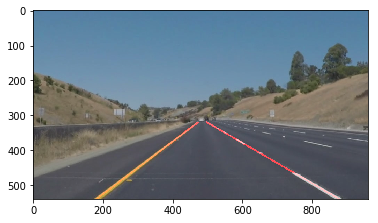

In [69]:
# single image test bench
import os
image_list = os.listdir("test_images/")
image_file = image_list[3]
image = mpimg.imread("test_images/" + image_file)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
print('Max:', image.max(), 'Min:', image.min())
# plt.imshow(image)
lanemark_image = process_image(image)
# plt.figure()
plt.imshow(lanemark_image)

In [2]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # printing out some stats and plotting
    # print('This image is:', type(image), 'with dimesions:', image.shape)
    # print('Max:', image.max(), 'Min:', image.min())
    # step 1: convert RBG image to Gray image
    gray = grayscale(image)
    # plt.imshow(gray, cmap='gray')
    # step 2: Gaussian Blur Filtering
    kernel_size = 5;
    blur_gray = gaussian_blur(gray, kernel_size)
    # plt.imshow(blur_gray, cmap='gray')
    # step 3: Apply Canny edges detection
    low_threshold = 100
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    # plt.imshow(edges, cmap='gray')
    # step 4: define region of interest for edge detection
    im_xsize = edges.shape[1]
    im_ysize = edges.shape[0]
    vertices = np.array([[(np.round(20/960*im_xsize), im_ysize), (np.round(440/960*im_xsize), np.round(320/540*im_ysize)), \
                          (np.round(520/960*im_xsize), np.round(320/540*im_ysize)), (np.round(940/960*im_xsize), im_ysize)]], dtype=np.int32)
    # vertices = np.array([[(100, im_ysize-50), (440, 320), (520, 320), (860, im_ysize-50)]], dtype=np.int32)
    # verify the region of interest in edges image
    # plt.imshow(edges, cmap='gray')
    # plt.plot(vertices[0, :, 0], vertices[0, :, 1], 'b--', lw=2)
    # display the edges with region of interest mask
    masked_edges = region_of_interest(edges, vertices)
    # plt.figure()
    # plt.imshow(masked_edges, cmap='gray')
    # step 5: Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    # apply Hough transform and draw extracted lines
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    # plt.imshow(line_image)
    # step 6: add extracted lane lines onto initial image
    lanemark_image = weighted_img(line_image, image)
    # plt.imshow(lanemark_image)
    
    return lanemark_image

In [13]:
# self-defined functions, based on examples
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# function to do weighted average
def weighted_avg(data):
    if data.size:
        weight = data[:, [2]]
        total_weight = np.sum(weight, 0)
        avg = np.sum(data[:, [0, 1]] * weight, 0)/total_weight
        return avg
    else:
        return np.empty_like(data)
    
# function to reject outliers
def reject_outliers(data):
    # to exclude outliers in data[:, 0]
    u = np.mean(data[:, 0])
    s = np.std(data[:, 0])
    filtered = np.array([e for e in data if (- 2 * s <= (e[0] - u) <= 2 * s)])
    return filtered

def draw_lines(img, lines, line_mode=0, y_ext=[320, 540], color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if line_mode == 1: # line averaging/extropolation mode
        # calculate slope of each line
        left_lines = np.empty((0, 3))
        right_lines = np.empty((0, 3))
        for line in lines:
            for x1,y1,x2,y2 in line:
                p = np.polyfit((x1, x2), (y1, y2), 1)
                line_len = np.array([np.sqrt((y2-y1)**2 + (x2-x1)**2)])
                if -0.85 < p[0] < -0.65:
                    left_lines = np.concatenate((left_lines, np.array([np.concatenate((p, line_len))])), axis=0)
                else:
                    if 0.5 < p[0] < 0.7:
                        right_lines = np.concatenate((right_lines, np.array([np.concatenate((p, line_len))])), axis=0)
        #print(left_lines, right_lines)       
        avg_lines = np.empty((0, 1, 4), dtype=np.int32)
        if left_lines.size:
            # to exclude outliers
            left_lines = reject_outliers(left_lines)
            # compute average
            # l_avg = np.mean(left_lines[:, [0, 1]], 0)
            l_avg = weighted_avg(left_lines)
            # print('Left lane', l_avg_old, l_avg)
            l_lane = np.array([[((y_ext[0]-l_avg[1])/l_avg[0], y_ext[0], (y_ext[1]-l_avg[1])/l_avg[0], y_ext[1])]], dtype=np.int32)
            avg_lines = np.concatenate((avg_lines, l_lane), axis=0)
        if right_lines.size:
            # to exclude outliers
            right_lines = reject_outliers(right_lines)
            # compute average
            # r_avg = np.mean(right_lines[:, [0, 1]], 0)
            r_avg = weighted_avg(right_lines)
            # print('Right lane', r_avg_old, r_avg)
            r_lane = np.array([[((y_ext[0]-r_avg[1])/r_avg[0], y_ext[0], (y_ext[1]-r_avg[1])/r_avg[0], y_ext[1])]], dtype=np.int32)
            avg_lines = np.concatenate((avg_lines, r_lane), axis=0)
        # print(avg_lines)
        for line in avg_lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, np.round(2*thickness))
    else:              # raw line mode, by default
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    im_xsize = img.shape[1]
    im_ysize = img.shape[0]
    draw_lines(line_img, lines, 1, [np.round(320/540*im_ysize), np.round(540/540*im_ysize)])
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)